# Sentiment Analysis on Mask Attituides in Time series in US

This notebook is an extension of notebook “Sentiment Analysis on Mask Attituides in US”<br>
Same Regex and vader tools are applied to the tweets<br>
The time series of the log-value of the postive and negative  mask-related tweets of the entire US are visualized in a time series are used and it is also used to compare the change in number of the confirmed covid-19 cases in US.<bf>
Similar linear plot of several states(CA,NV,OR..) are also plotted togather with its confirmed cases in weekly basis.They are used to detect the similariy betweem the adjacent states.

In [1]:
import pandas as pd
import ast
import re
import math
import matplotlib.pyplot as plt
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
from datetime import timedelta
from matplotlib.pyplot import MultipleLocator
from matplotlib import dates as mpl_dates

In [2]:
#load dataframe
tws_df = pd.read_csv('/home/zhoulita/scratch/covid_data_unprocessed/dataFrame/tweet_df_loc_total.csv',low_memory=False,lineterminator='\n')

def get_week_index(df):
    return int((df['day_index']-1)/7)
tws_df['week_index']= tws_df.apply(get_week_index,axis = 1)
#remove unnecessary column
tws_df.drop(['lang', 'referenced_tweets','author_id', 'source', 'possibly_sensitive', 'public_metrics','entities', 'context_annotations', 'in_reply_to_user_id', 'attachments'], axis=1, inplace=True)
tws_df.drop(['Unnamed: 0', 'Unnamed: 0.1','geo_x', 'id_y', 'withheld'], axis=1, inplace=True)

In [3]:
#load the us places with the state code
us_pls_df = pd.read_csv("/home/zhoulita/scratch/covid_19_tweets/us_places.csv")
us_pls_df.drop(['Unnamed: 0', 'full_name','place_type', 'country_code', 'country','geo','name','Lontitude','Latitude'], axis=1, inplace=True)

In [4]:
total_df = pd.merge(tws_df,us_pls_df,how = 'inner',left_on = 'geo_id',right_on = 'id')
total_df.drop(['place_type', 'country','place_type', 'Lontitude', 'geo_y','Latitude','id'], axis=1, inplace=True)

In [5]:
#text cleaning
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)



#define a function to clean the text
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text)#remove the @
    text = re.sub(r'#','',text) #remove the #
    text = re.sub(r'RT[\s]+','',text) #remove retweet
    text = re.sub(r'https?:\/\/\S+','',text) #remove http 
    text =  re.sub('\n','',text)
    text = re.sub('\S*@\S*\s?', '', text)#remove email
    text = re.sub('\s+', ' ', text)
    text = remove_emoji(text)
    return text

total_df['processed_text'] = total_df['text'].apply(clean_text)

In [6]:
#use regex to clean and filter out the useful info from tweets related to family 
#also filter out the word related to us election
regex_election = re.compile(r'(?i)Trump|Biden|Election|democratic|republican|party|President|campaign|elector|candidate') 
regex_mask = re.compile(r'(?i)mask|Mask')

def mask_related_text(text):
    if regex_mask.search(text):
        return True
    return False

def election_related_text(text):
    if regex_election.search(text):
        return True
    return False

total_df['election_related'] = total_df['processed_text'].apply(election_related_text)
total_df['mask_related'] = total_df['processed_text'].apply(mask_related_text)


In [7]:
mask_related_df = total_df[(total_df["mask_related"]==True)&(total_df["election_related"]==False)]

In [8]:
#using nature language processing tools Vader to seperate the postive and negative tweets of mask
vader = SentimentIntensityAnalyzer()

#define a function to get the subjectivity and polarity of the twitter
def get_text_polarity(text):
    return vader.polarity_scores(text)['compound']

mask_related_df['text_polarity_value'] = mask_related_df['processed_text'].apply(get_text_polarity)


/tmp/ipykernel_224402/3535561598.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_related_df['text_polarity_value'] = mask_related_df['processed_text'].apply(get_text_polarity)


In [18]:
#create a data frame that counts the number of tweets in each week
tweets_counts_df = pd.DataFrame()

for i in range(0,50):
    current_mask_df = mask_related_df[mask_related_df['week_index']==i]
    current_df = total_df[total_df['week_index']==i]
    mask_related_tweets_num = len(current_mask_df)
    tweets_num = len(current_df)
    tweets_counts_df = tweets_counts_df.append(pd.Series([int(i), int(tweets_num), int(mask_related_tweets_num)]), ignore_index=True)
                                                     
tweets_counts_df.columns = ['week_index', 'tweets_counts','Mask_related_tweets_counts']

In [60]:
#function to get the time in second for the area
def get_date_index(df):
    if df['week_index'] == 0:
        return int(datetime.strptime('2020-03-19', '%Y-%m-%d').timestamp())
    else:
        timedel = timedelta(weeks = df['week_index'] )
        time_week = datetime.strptime('2020-03-19', '%Y-%m-%d') + timedel
        return int(time_week.timestamp())
    
tweets_counts_df['Date_Sec'] = tweets_counts_df.apply(get_date_index,axis = 1)

In [20]:
#calcuated mask related tweets compare to the overall number of tweets
tweets_counts_df['Mask_related_tweets_percentage'] = tweets_counts_df['Mask_related_tweets_counts']/tweets_counts_df['tweets_counts']

In [21]:
pos_mask_related_df = mask_related_df[mask_related_df["text_polarity_value"]>0]
neg_mask_related_df = mask_related_df[mask_related_df["text_polarity_value"]<0]

In [28]:
# define functions to get the number of postive and negative tweets of the week
def get_postive_tweets_num(df):
    return len(pos_mask_related_df[pos_mask_related_df['week_index']==df['week_index']])

def get_negative_tweets_num(df):
    return len(neg_mask_related_df[neg_mask_related_df['week_index']==df['week_index']])

def get_pos_neg_counts_ratio(df):
    return math.log((df['Pos_mask_related_tweets_count']/df['Neg_mask_related_tweets_count']))

tweets_counts_df['Pos_mask_related_tweets_count'] = tweets_counts_df.apply(get_postive_tweets_num,axis = 1)
tweets_counts_df['Neg_mask_related_tweets_count'] = tweets_counts_df.apply(get_negative_tweets_num,axis = 1)
tweets_counts_df['Pos_Neg_counts_log_ratio'] = tweets_counts_df.apply(get_pos_neg_counts_ratio,axis =1)

In [30]:
tweets_counts_df.head(3)

,week_index,tweets_counts,Mask_related_tweets_counts,Date_Sec,Mask_related_tweets_percentage,Pos_mask_related_tweets_count,Neg_mask_related_tweets_count,Pos_Neg_counts_log_ratio
0,0.0,29305.0,164.0,1584601200,0.005596,82,47,0.556572
1,1.0,24768.0,182.0,1585206000,0.007348,76,57,0.287682
2,2.0,17237.0,286.0,1585810800,0.016592,135,77,0.561469


In [34]:
#load the data and the covid cases/death of the the week
#read the file of covid data of US 
country_covid_df = pd.read_csv("/home/zhoulita/scratch/covid_19_tweets/international-covid-data.csv",usecols = ['iso_code','date','new_cases','new_deaths'])
country_covid_df['new_cases'].fillna(0)
country_covid_df['new_deaths'].fillna(0)
country_covid_df = country_covid_df[country_covid_df['iso_code']=="USA"]

#remove the date that is out of the bounb 
def check_date_inbound(df):
    start_date = datetime.strptime('2020-03-19', '%Y-%m-%d')
    delta = int((datetime.strptime(df['date'], '%Y-%m-%d')-start_date).days)
    if delta < 0:
        return False
    else:
        return True

country_covid_df['date_inbound'] = country_covid_df.apply(check_date_inbound,axis = 1)
country_covid_df = country_covid_df[country_covid_df['date_inbound'] == True]
del country_covid_df['date_inbound']

#get the week index
def get_week_index(df):
    start_date = datetime.strptime('2020-03-19', '%Y-%m-%d')
    delta = int((datetime.strptime(df['date'], '%Y-%m-%d')-start_date).days)    
    return int(delta/7)

country_covid_df['week_index'] = country_covid_df.apply(get_week_index,axis = 1)

In [37]:
country_covid_df.head(3)

,iso_code,date,new_cases,new_deaths,week_index
94215,USA,2020-03-19,4494.0,72.0,0
94216,USA,2020-03-20,6367.0,106.0,0
94217,USA,2020-03-21,5995.0,103.0,0


In [40]:
#get the value of case and death
def get_new_cases_value(df):
    temp_df = country_covid_df[country_covid_df['week_index']==df['week_index']]
    return temp_df['new_cases'].sum()

tweets_counts_df['new_cases'] = tweets_counts_df.apply(get_new_cases_value,axis = 1)

#get the value of case and death
def get_new_deaths_value(df):
    temp_df = country_covid_df[country_covid_df['week_index']==df['week_index']]
    return temp_df['new_deaths'].sum()

tweets_counts_df['new_deaths'] = tweets_counts_df.apply(get_new_deaths_value,axis = 1)

In [80]:
tweets_counts_df['Date'] = pd.to_datetime(tweets_counts_df['Date_Sec'],unit='s')

In [128]:
tweets_counts_df.head(3)

,week_index,tweets_counts,Mask_related_tweets_counts,Mask_related_tweets_percentage,Pos_mask_related_tweets_count,Neg_mask_related_tweets_count,Pos_Neg_counts_log_ratio,new_cases,new_deaths,Date_Sec,Date
0,0.0,29305.0,164.0,0.005596,82,47,0.556572,59668.0,1173.0,1584601200,2020-03-19 07:00:00
1,1.0,24768.0,182.0,0.007348,76,57,0.287682,155750.0,5288.0,1585206000,2020-03-26 07:00:00
2,2.0,17237.0,286.0,0.016592,135,77,0.561469,220214.0,12632.0,1585810800,2020-04-02 07:00:00


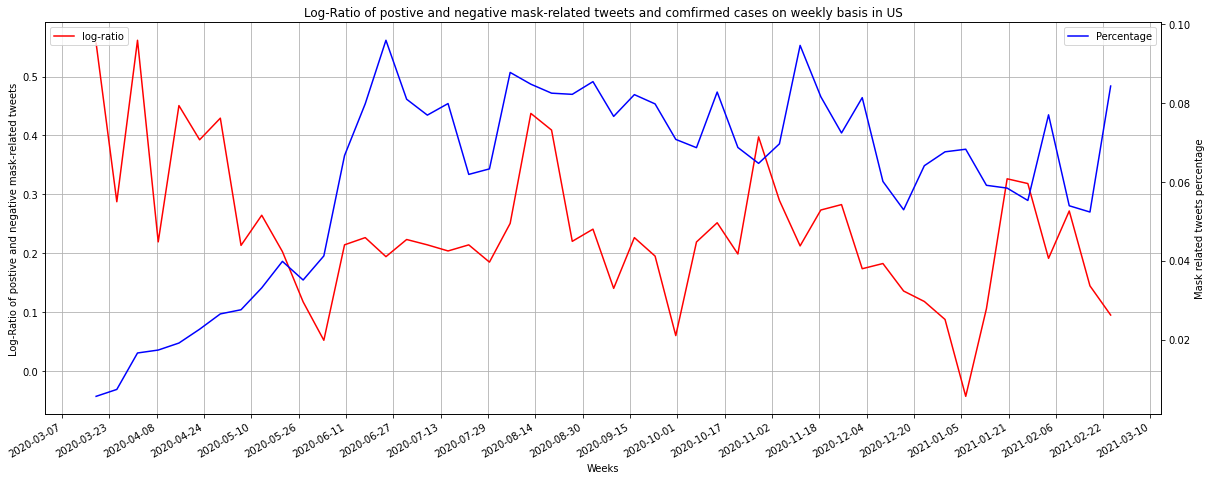

In [136]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(111)
ax1.plot(tweets_counts_df['Date'],tweets_counts_df['Pos_Neg_counts_log_ratio'],'r')
ax1.set_ylabel('Log-Ratio of postive and negative mask-related tweets')
ax1.set_xlabel('Weeks')
ax1.set_title("Log-Ratio of postive and negative mask-related tweets and comfirmed cases on weekly basis in US")
plt.legend(['log-ratio'],loc = 2)

plt.grid()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(tweets_counts_df['Date'],tweets_counts_df['Mask_related_tweets_percentage'],'b')
ax2.set_ylabel('Mask related tweets percentage')

ax=plt.gca()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=23040))
plt.legend(['Percentage'],loc = 1)


plt.show()

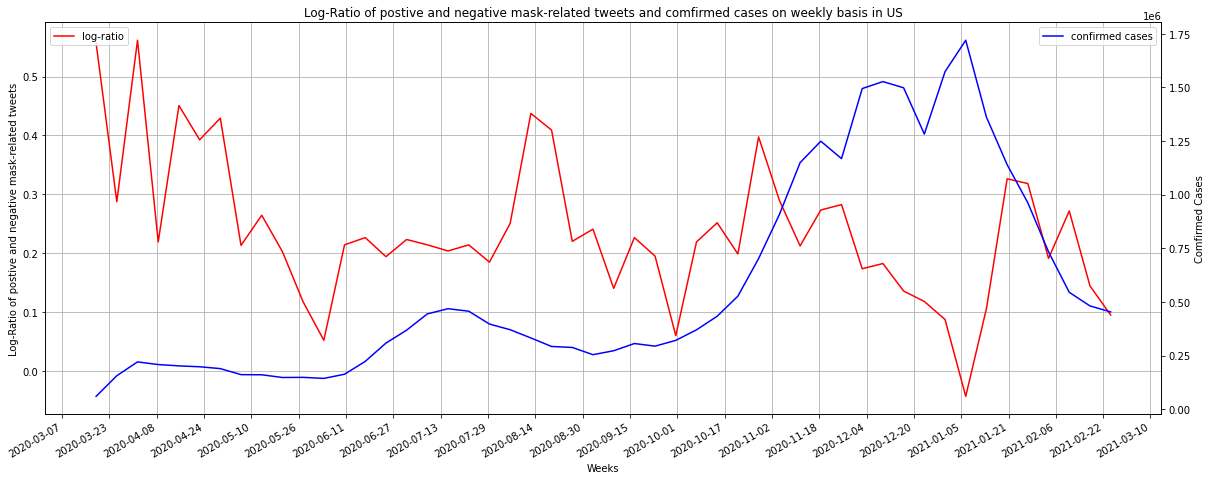

In [137]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(111)
ax1.plot(tweets_counts_df['Date'],tweets_counts_df['Pos_Neg_counts_log_ratio'],'r')
ax1.set_ylabel('Log-Ratio of postive and negative mask-related tweets')
ax1.set_xlabel('Weeks')
ax1.set_title("Log-Ratio of postive and negative mask-related tweets and comfirmed cases on weekly basis in US")
plt.legend(['log-ratio'],loc = 2)

plt.grid()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(tweets_counts_df['Date'],tweets_counts_df['new_cases'],'b')
ax2.set_ylabel('Comfirmed Cases')

ax=plt.gca()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=23040))
plt.legend(['confirmed cases'],loc = 1)


plt.show()

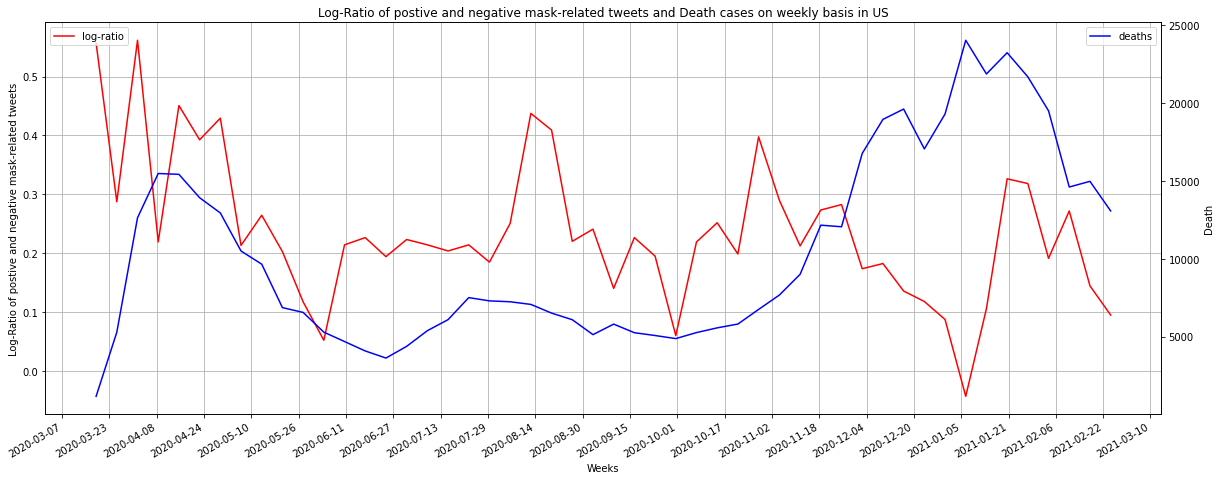

In [138]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(111)
ax1.plot(tweets_counts_df['Date'],tweets_counts_df['Pos_Neg_counts_log_ratio'],'r')
ax1.set_ylabel('Log-Ratio of postive and negative mask-related tweets')
ax1.set_xlabel('Weeks')
ax1.set_title("Log-Ratio of postive and negative mask-related tweets and Death cases on weekly basis in US")
plt.legend(['log-ratio'],loc = 2)

plt.grid()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(tweets_counts_df['Date'],tweets_counts_df['new_deaths'],'b')
ax2.set_ylabel('Death')
plt.legend(['deaths'],loc = 1)

ax=plt.gca()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=23040))

plt.show()

Visualize the log value of postive tweets/negative mask-related tweets counts over the new confirmed cases and new death of two  states in time series<br>

In [121]:
# #read the file of covid data in us
covid_states_df = pd.read_csv("/home/zhoulita/scratch/covid_19_tweets/all-states-history.csv",usecols = ['date','state','positiveIncrease','deathIncrease','hospitalized'])

covid_states_df['positiveIncrease'] = covid_states_df['positiveIncrease'].fillna(0)
covid_states_df['deathIncrease'] = covid_states_df['deathIncrease'].fillna(0)
covid_states_df['hospitalized'] = covid_states_df['hospitalized'].fillna(0)

covid_states_df['date_inbound'] = covid_states_df.apply(check_date_inbound,axis = 1)
covid_states_df = covid_states_df[covid_states_df['date_inbound'] == True]
del covid_states_df['date_inbound']
covid_states_df['week_index'] = covid_states_df.apply(get_week_index,axis = 1)
#remove Hawaii and Alaska from the list
covid_states_df = covid_states_df[(covid_states_df['state']!='AK')&(covid_states_df['state']!='HA')]
covid_states_df 

,date,state,deathIncrease,hospitalized,positiveIncrease,week_index
1,2021-03-07,AL,-1,45976.0,408,50
2,2021-03-07,AR,22,14926.0,165,50
3,2021-03-07,AS,0,0.0,0,50
4,2021-03-07,AZ,5,57907.0,1335,50
5,2021-03-07,CA,258,0.0,3816,50
...,...,...,...,...,...,...
19819,2020-03-19,VT,0,0.0,2,0
19820,2020-03-19,WA,10,0.0,268,0
19821,2020-03-19,WI,0,0.0,53,0
19822,2020-03-19,WV,0,0.0,1,0


In [124]:
#create a data frame that counts the number of tweets in each week in each state
pos_neg_tweets_states_df = pd.DataFrame()

states_list = mask_related_df['States'].unique().tolist()
states_idx = range(len(states_list))

for i in range(0,50):
    for j in states_idx:
        current_state = states_list[j]
        current_df = mask_related_df[(mask_related_df["States"]==current_state)&(mask_related_df["week_index"]==i)]
        pos_tweets_num = len(current_df[current_df['text_polarity_value']>0])
        neg_tweets_num = len(current_df[current_df['text_polarity_value']<0])
        
        pos_neg_tweets_states_df = pos_neg_tweets_states_df.append(pd.Series([int(i),current_state, int(pos_tweets_num), int(neg_tweets_num)]), ignore_index=True)
                                                     
pos_neg_tweets_states_df.columns = ['week_index','state','Pos_mask_related_tweets_count','Neg_mask_related_tweets_count']

pos_neg_tweets_states_df['Date_Sec'] = pos_neg_tweets_states_df.apply(get_date_index,axis = 1)

#define the function to get log value of the pos/neg tweets
def get_pos_neg_counts_ratio(df):
    if df['Pos_mask_related_tweets_count'] == 0 or df['Neg_mask_related_tweets_count'] ==0:
        return "No"
    return math.log((df['Pos_mask_related_tweets_count']/df['Neg_mask_related_tweets_count']))

pos_neg_tweets_states_df['Pos_Neg_counts_log_ratio'] = pos_neg_tweets_states_df.apply(get_pos_neg_counts_ratio,axis =1)

#remove the log value of not exist
pos_neg_tweets_states_df= pos_neg_tweets_states_df[pos_neg_tweets_states_df['Pos_Neg_counts_log_ratio'] !='No']

In [126]:
#define the function to get the current week increase number of confirmed case
def get_state_confirmed_cases(df):
    current_week = df['week_index']
    current_state = df['state']
    covid_week_state_df = covid_states_df[(covid_states_df['week_index']==current_week)&(covid_states_df['state']==current_state)]
    return covid_week_state_df['positiveIncrease'].sum()
#define the function to get the current week increase number of confirmed case
def get_state_hospitalize_cases(df):
    current_week = df['week_index']
    current_state = df['state']
    covid_week_state_df = covid_states_df[(covid_states_df['week_index']==current_week)&(covid_states_df['state']==current_state)]
    return covid_week_state_df['hospitalized'].sum()

#define the function to get the current week increase number of confirmed case
def get_state_death_cases(df):
    current_week = df['week_index']
    current_state = df['state']
    covid_week_state_df = covid_states_df[(covid_states_df['week_index']==current_week)&(covid_states_df['state']==current_state)]
    return covid_week_state_df['deathIncrease'].sum()


pos_neg_tweets_states_df['new_cases'] = pos_neg_tweets_states_df.apply(get_state_confirmed_cases,axis =1)
pos_neg_tweets_states_df['new_death'] = pos_neg_tweets_states_df.apply(get_state_death_cases,axis =1)
pos_neg_tweets_states_df['new_hospitalized_cases'] = pos_neg_tweets_states_df.apply(get_state_hospitalize_cases,axis =1)

In [129]:
pos_neg_tweets_states_df['Date'] = pd.to_datetime(pos_neg_tweets_states_df['Date_Sec'],unit='s')
pos_neg_tweets_states_df['Date_Sec'] = pos_neg_tweets_states_df.apply(get_date_index,axis = 1)


In [130]:
pos_neg_tweets_states_df.head(3)

,week_index,state,Pos_mask_related_tweets_count,Neg_mask_related_tweets_count,Date_Sec,Pos_Neg_counts_log_ratio,new_cases,new_death,new_hospitalized_cases,Date
0,0.0,CA,17.0,9.0,1584601200,0.635989,1744,40,0.0,2020-03-19 07:00:00
1,0.0,FL,5.0,3.0,1584601200,0.510826,1277,15,1135.0,2020-03-19 07:00:00
2,0.0,TX,7.0,2.0,1584601200,1.252763,893,10,0.0,2020-03-19 07:00:00


California

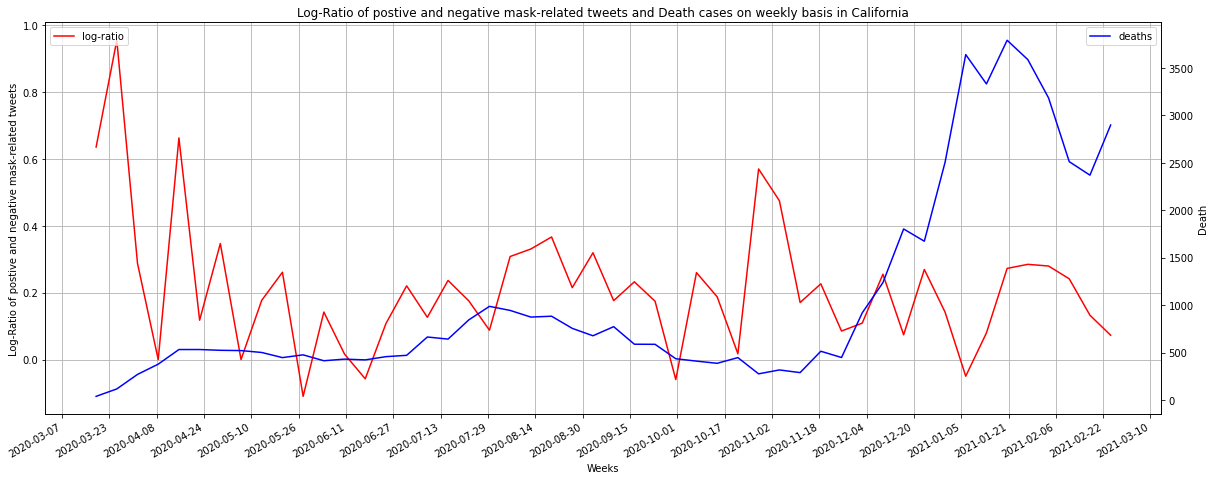

In [139]:
state = 'CA'
df= pos_neg_tweets_states_df[(pos_neg_tweets_states_df['state'] ==state)]

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(111)
ax1.plot(df['Date'],df['Pos_Neg_counts_log_ratio'],'r')
ax1.set_ylabel('Log-Ratio of postive and negative mask-related tweets')
ax1.set_xlabel('Weeks')
ax1.set_title("Log-Ratio of postive and negative mask-related tweets and Death cases on weekly basis in California")
plt.legend(['log-ratio'],loc = 2)

plt.grid()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(df['Date'],df['new_death'],'b')
ax2.set_ylabel('Death')
plt.legend(['deaths'],loc = 1)

ax=plt.gca()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=23040))

plt.show()

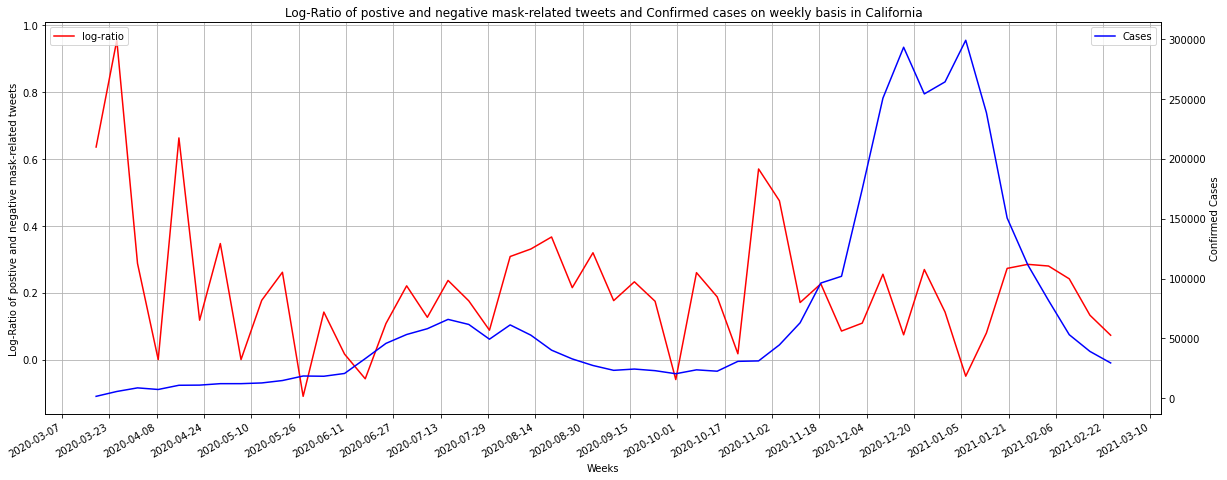

In [140]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(111)
ax1.plot(df['Date'],df['Pos_Neg_counts_log_ratio'],'r')
ax1.set_ylabel('Log-Ratio of postive and negative mask-related tweets')
ax1.set_xlabel('Weeks')
ax1.set_title("Log-Ratio of postive and negative mask-related tweets and Confirmed cases on weekly basis in California")
plt.legend(['log-ratio'],loc = 2)

plt.grid()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(df['Date'],df['new_cases'],'b')
ax2.set_ylabel('Confirmed Cases')
plt.legend(['Cases'],loc = 1)

ax=plt.gca()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=23040))

plt.show()

Nevada

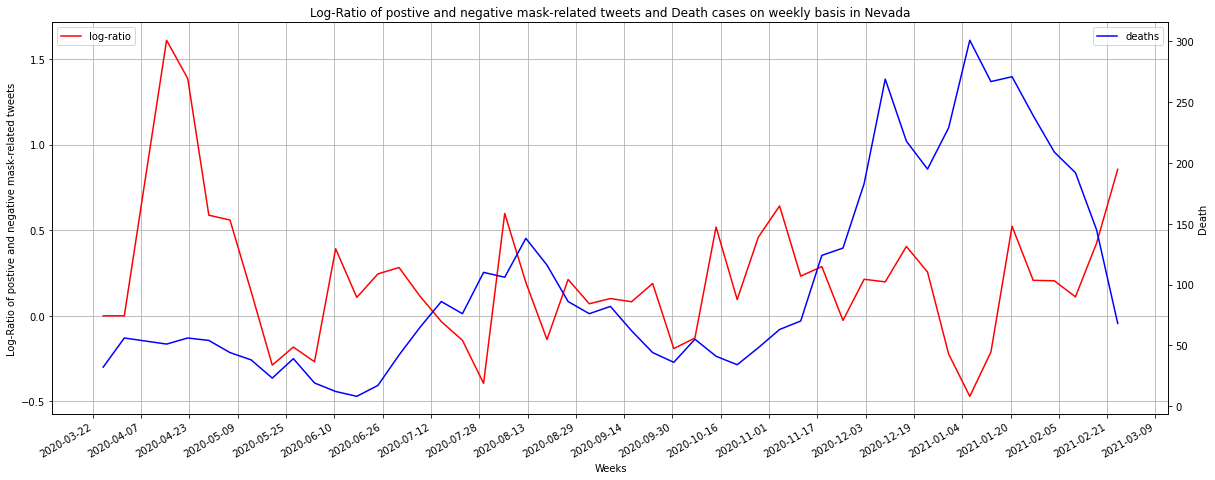

In [143]:
state = 'NV'
df= pos_neg_tweets_states_df[(pos_neg_tweets_states_df['state'] ==state)]

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(111)
ax1.plot(df['Date'],df['Pos_Neg_counts_log_ratio'],'r')
ax1.set_ylabel('Log-Ratio of postive and negative mask-related tweets')
ax1.set_xlabel('Weeks')
ax1.set_title("Log-Ratio of postive and negative mask-related tweets and Death cases on weekly basis in Nevada")
plt.legend(['log-ratio'],loc = 2)

plt.grid()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(df['Date'],df['new_death'],'b')
ax2.set_ylabel('Death')
plt.legend(['deaths'],loc = 1)

ax=plt.gca()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=23040))

plt.show()

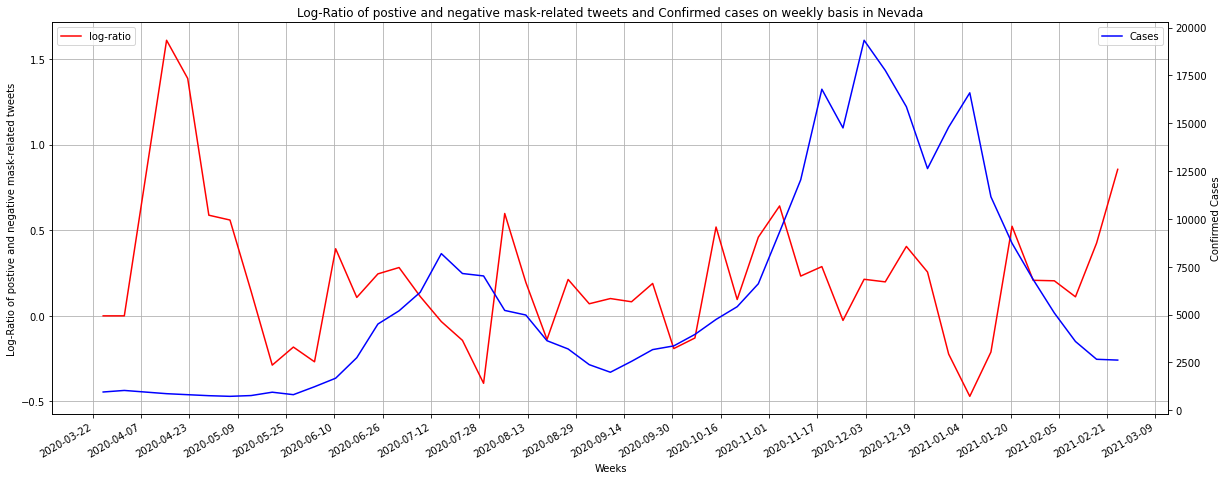

In [145]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(111)
ax1.plot(df['Date'],df['Pos_Neg_counts_log_ratio'],'r')
ax1.set_ylabel('Log-Ratio of postive and negative mask-related tweets')
ax1.set_xlabel('Weeks')
ax1.set_title("Log-Ratio of postive and negative mask-related tweets and Confirmed cases on weekly basis in Nevada")
plt.legend(['log-ratio'],loc = 2)

plt.grid()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(df['Date'],df['new_cases'],'b')
ax2.set_ylabel('Confirmed Cases')
plt.legend(['Cases'],loc = 1)

ax=plt.gca()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=23040))

plt.show()

Texas

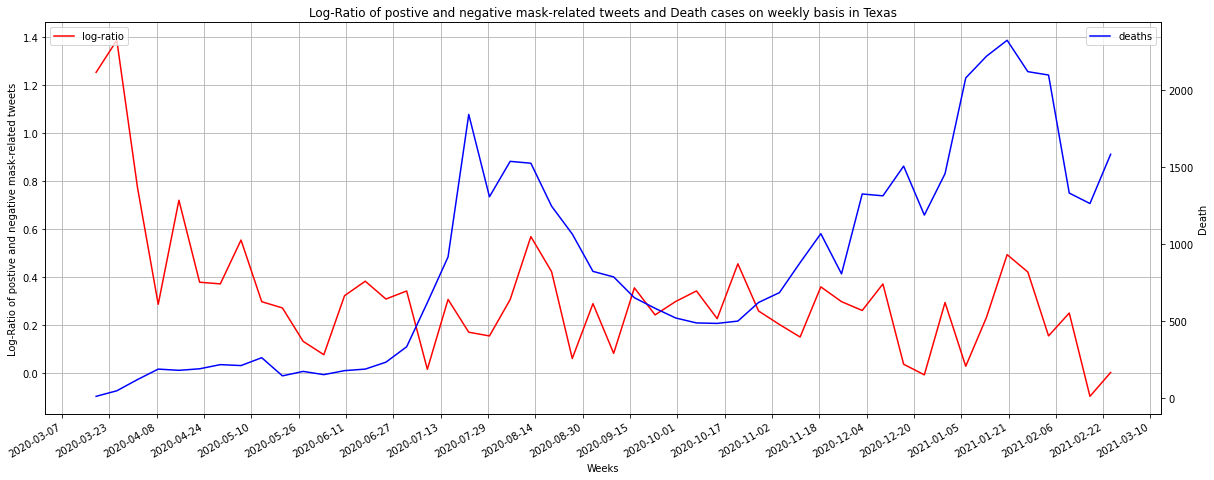

In [146]:
state = 'TX'
df= pos_neg_tweets_states_df[(pos_neg_tweets_states_df['state'] ==state)]

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(111)
ax1.plot(df['Date'],df['Pos_Neg_counts_log_ratio'],'r')
ax1.set_ylabel('Log-Ratio of postive and negative mask-related tweets')
ax1.set_xlabel('Weeks')
ax1.set_title("Log-Ratio of postive and negative mask-related tweets and Death cases on weekly basis in Texas")
plt.legend(['log-ratio'],loc = 2)

plt.grid()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(df['Date'],df['new_death'],'b')
ax2.set_ylabel('Death')
plt.legend(['deaths'],loc = 1)

ax=plt.gca()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=23040))

plt.show()

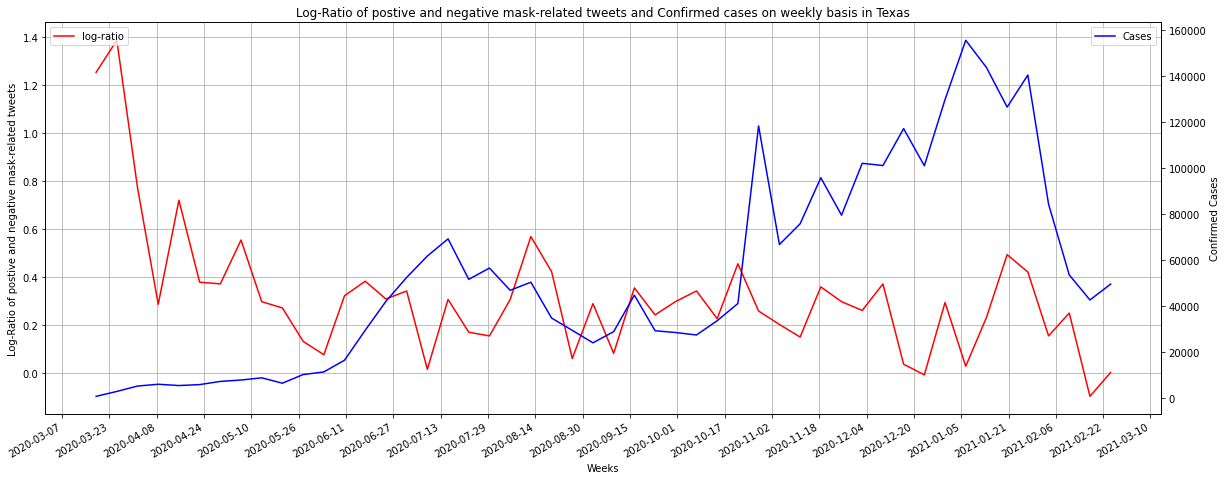

In [148]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(111)
ax1.plot(df['Date'],df['Pos_Neg_counts_log_ratio'],'r')
ax1.set_ylabel('Log-Ratio of postive and negative mask-related tweets')
ax1.set_xlabel('Weeks')
ax1.set_title("Log-Ratio of postive and negative mask-related tweets and Confirmed cases on weekly basis in Texas")
plt.legend(['log-ratio'],loc = 2)

plt.grid()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(df['Date'],df['new_cases'],'b')
ax2.set_ylabel('Confirmed Cases')
plt.legend(['Cases'],loc = 1)

ax=plt.gca()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=23040))

plt.show()